In [1]:
# 📦 Installation (compatible Python 3.12)
!pip install torch pyro-ppl numpy pandas matplotlib scikit-learn arviz --quiet



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: C:\Users\lauri\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
import pyro
import pyro.distributions as dist
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyro.infer import MCMC, NUTS, SVI, Trace_ELBO
from pyro.optim import Adam
from sklearn.metrics import accuracy_score

# Simuler données CTR
n_docs = 5
n_sessions = 1000
true_relevance = np.random.beta(2, 5, size=n_docs)
position_bias = np.linspace(1.0, 0.2, n_docs)

click_data = []
for _ in range(n_sessions):
    session = []
    for i in range(n_docs):
        prob = true_relevance[i] * position_bias[i]
        click = np.random.binomial(1, prob)
        session.append(click)
    click_data.append(session)

click_df = pd.DataFrame(click_data, columns=[f'doc_{i+1}' for i in range(n_docs)])
click_totals = click_df.sum(axis=0).values


c:\Users\lauri\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Modèle 1 – Régression Logistique Bayésienne (NUTS)

In [3]:
def click_model_1(click_totals, n_docs):
    relevance = pyro.sample("relevance", dist.Beta(torch.ones(n_docs), torch.ones(n_docs)))
    exam_bias = pyro.sample("exam_bias", dist.Beta(torch.ones(n_docs), torch.ones(n_docs)))
    probs = relevance * exam_bias
    with pyro.plate("data", n_docs):
        pyro.sample("clicks", dist.Binomial(total_count=n_sessions, probs=probs),
                    obs=torch.tensor(click_totals))


In [4]:
nuts_kernel = NUTS(click_model_1)
mcmc = MCMC(nuts_kernel, num_samples=500, warmup_steps=200, num_chains=1)
mcmc.run(click_totals, n_docs)
samples = mcmc.get_samples()
relevance_mean = samples["relevance"].mean(0).numpy()
exam_mean = samples["exam_bias"].mean(0).numpy()


Sample: 100%|██████████| 700/700 [01:51,  6.31it/s, step size=6.08e-02, acc. prob=0.920]


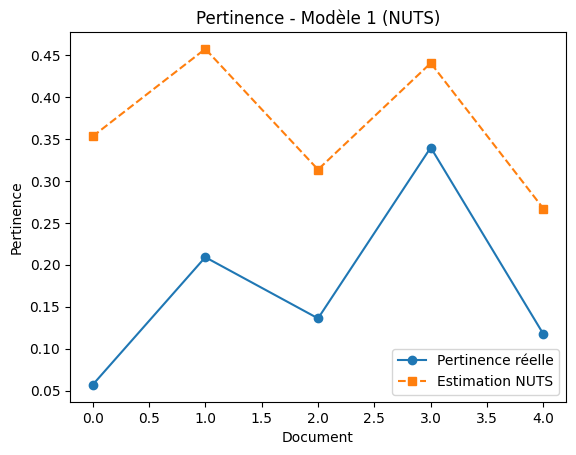

In [5]:
plt.plot(true_relevance, 'o-', label="Pertinence réelle")
plt.plot(relevance_mean, 's--', label="Estimation NUTS")
plt.title("Pertinence - Modèle 1 (NUTS)")
plt.xlabel("Document")
plt.ylabel("Pertinence")
plt.legend()
plt.show()


### Modèle 2 – SVI (version scalaire initiale)

In [6]:
def model_nn_scalar(click_count, position):
    weight = pyro.sample("weight", dist.Normal(0., 1.))
    bias = pyro.sample("bias", dist.Normal(0., 1.))
    prob = torch.sigmoid(weight * position + bias)
    pyro.sample("click", dist.Binomial(total_count=n_sessions, probs=prob),
                obs=torch.tensor(click_count, dtype=torch.float32))

def guide_nn_scalar(click_count, position):
    weight_loc = pyro.param("weight_loc", torch.tensor(0.))
    weight_scale = pyro.param("weight_scale", torch.tensor(1.), constraint=dist.constraints.positive)
    bias_loc = pyro.param("bias_loc", torch.tensor(0.))
    bias_scale = pyro.param("bias_scale", torch.tensor(1.), constraint=dist.constraints.positive)
    pyro.sample("weight", dist.Normal(weight_loc, weight_scale))
    pyro.sample("bias", dist.Normal(bias_loc, bias_scale))


In [7]:
results = []
for i in range(n_docs):
    pyro.clear_param_store()
    click_count = click_totals[i]
    position = position_bias[i]
    svi = SVI(model_nn_scalar, guide_nn_scalar, Adam({"lr": 0.01}), loss=Trace_ELBO())
    for step in range(1000):
        svi.step(click_count, position)
    w = pyro.param("weight_loc").item()
    b = pyro.param("bias_loc").item()
    results.append((w, b))


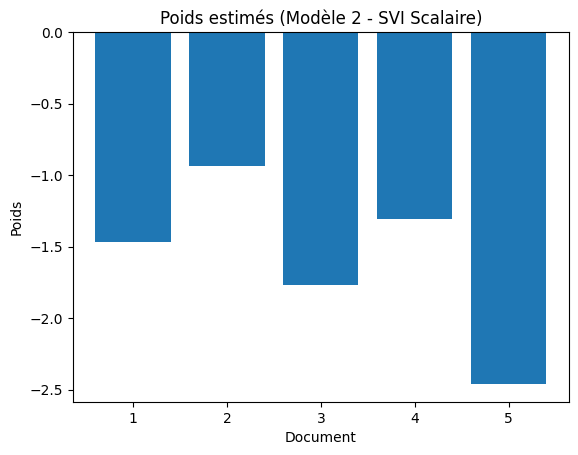

In [8]:
weights = [w for w, _ in results]
plt.bar(range(1, n_docs + 1), weights)
plt.title("Poids estimés (Modèle 2 - SVI Scalaire)")
plt.xlabel("Document")
plt.ylabel("Poids")
plt.show()


### Modèle 3 – SVI amélioré (estimation directe de la pertinence)

In [9]:
def model_svi_improved(click_count, position):
    relevance = pyro.sample("relevance", dist.Beta(1., 1.))  # pertinence latente
    logit = torch.log(position + 1e-6) + torch.log(relevance + 1e-6)
    prob = torch.sigmoid(logit)
    pyro.sample("click", dist.Binomial(total_count=n_sessions, probs=prob),
                obs=torch.tensor(click_count, dtype=torch.float32))

def guide_svi_improved(click_count, position):
    rel_alpha = pyro.param("rel_alpha", torch.tensor(1.), constraint=dist.constraints.positive)
    rel_beta = pyro.param("rel_beta", torch.tensor(1.), constraint=dist.constraints.positive)
    pyro.sample("relevance", dist.Beta(rel_alpha, rel_beta))


In [11]:
relevance_estimates = []

for i in range(n_docs):
    pyro.clear_param_store()
    click_count = click_totals[i]
    position = torch.tensor(position_bias[i])

    svi = SVI(model_svi_improved, guide_svi_improved, Adam({"lr": 0.01}), loss=Trace_ELBO())

    for step in range(1000):
        svi.step(click_count, position)

    alpha = pyro.param("rel_alpha").item()
    beta = pyro.param("rel_beta").item()
    est = alpha / (alpha + beta)
    relevance_estimates.append(est)
    print(f" Doc {i+1} → Pertinence estimée = {est:.3f}")


 Doc 1 → Pertinence estimée = 0.076
 Doc 2 → Pertinence estimée = 0.270
 Doc 3 → Pertinence estimée = 0.111
 Doc 4 → Pertinence estimée = 0.421
 Doc 5 → Pertinence estimée = 0.176


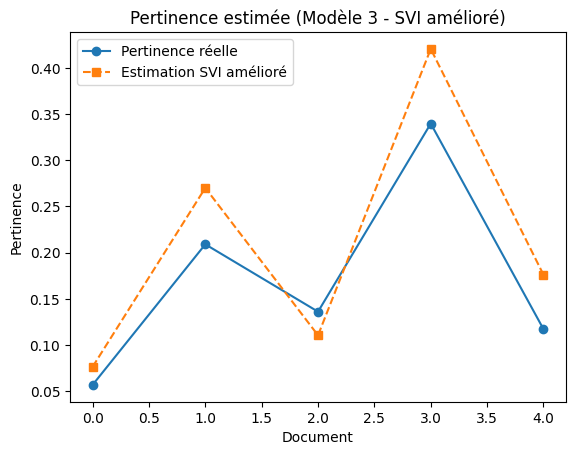

In [12]:
plt.plot(true_relevance, 'o-', label="Pertinence réelle")
plt.plot(relevance_estimates, 's--', label="Estimation SVI amélioré")
plt.title("Pertinence estimée (Modèle 3 - SVI amélioré)")
plt.xlabel("Document")
plt.ylabel("Pertinence")
plt.legend()
plt.show()


### Modèle 4 – SVI avec deux variables latentes (pertinence + biais de position)

In [13]:
def model_svi_enhanced(click_count, position):
    relevance = pyro.sample("relevance", dist.Beta(1., 1.))
    exam_bias = pyro.sample("exam_bias", dist.Beta(1., 1.))
    logit = torch.log(position + 1e-6) + torch.log(relevance + 1e-6) + torch.log(exam_bias + 1e-6)
    prob = torch.sigmoid(logit)
    pyro.sample("click", dist.Binomial(total_count=n_sessions, probs=prob),
                obs=torch.tensor(click_count, dtype=torch.float32))

def guide_svi_enhanced(click_count, position):
    rel_alpha = pyro.param("rel_alpha_4", torch.tensor(1.), constraint=dist.constraints.positive)
    rel_beta = pyro.param("rel_beta_4", torch.tensor(1.), constraint=dist.constraints.positive)
    exam_alpha = pyro.param("exam_alpha_4", torch.tensor(1.), constraint=dist.constraints.positive)
    exam_beta = pyro.param("exam_beta_4", torch.tensor(1.), constraint=dist.constraints.positive)
    pyro.sample("relevance", dist.Beta(rel_alpha, rel_beta))
    pyro.sample("exam_bias", dist.Beta(exam_alpha, exam_beta))


In [15]:
relevance_estimates_4 = []

for i in range(n_docs):
    pyro.clear_param_store()
    click_count = click_totals[i]
    position = torch.tensor(position_bias[i])

    svi = SVI(model_svi_enhanced, guide_svi_enhanced, Adam({"lr": 0.01}), loss=Trace_ELBO())

    for step in range(1000):
        svi.step(click_count, position)

    alpha = pyro.param("rel_alpha_4").item()
    beta = pyro.param("rel_beta_4").item()
    est = alpha / (alpha + beta)
    relevance_estimates_4.append(est)
    print(f" Doc {i+1} → Pertinence estimée (modèle 4) = {est:.3f}")


 Doc 1 → Pertinence estimée (modèle 4) = 0.293
 Doc 2 → Pertinence estimée (modèle 4) = 0.544
 Doc 3 → Pertinence estimée (modèle 4) = 0.337
 Doc 4 → Pertinence estimée (modèle 4) = 0.673
 Doc 5 → Pertinence estimée (modèle 4) = 0.378


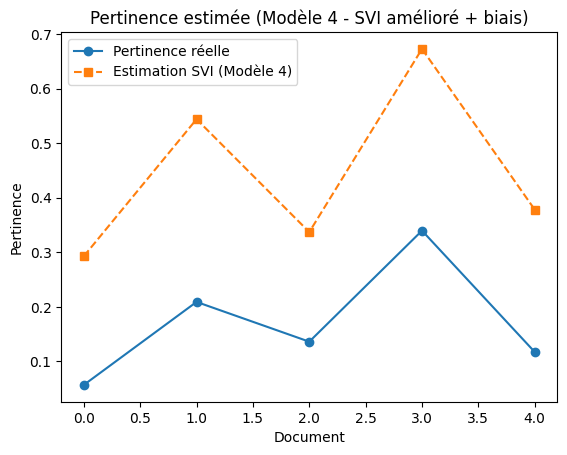

In [16]:
plt.plot(true_relevance, 'o-', label="Pertinence réelle")
plt.plot(relevance_estimates_4, 's--', label="Estimation SVI (Modèle 4)")
plt.title("Pertinence estimée (Modèle 4 - SVI amélioré + biais)")
plt.xlabel("Document")
plt.ylabel("Pertinence")
plt.legend()
plt.show()
